In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid

In [2]:
class MoneyAgent(Agent):
    """An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1
    
    def step(self):
        if self.wealth == 0:
            return
        other_agent = self.random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
    
    def step(self):
        """Advance the model by one step."""
        self.schedule.step()

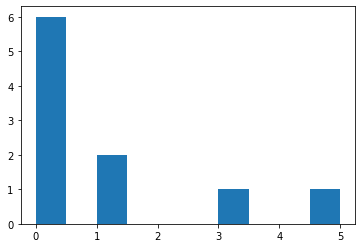

In [3]:
model = MoneyModel(10)
for i in range(10):
    model.step()
    
agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth);

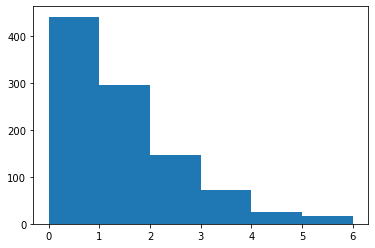

In [4]:
all_wealth = []
for j in range(100):
    # Run the model
    model = MoneyModel(10)
    for i in range(10):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

plt.hist(all_wealth, bins=range(max(all_wealth)+1));

In [5]:
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

    def step(self):
        self.schedule.step()

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

In [6]:
model = MoneyModel(50, 10, 10)
for i in range(20):
    model.step()

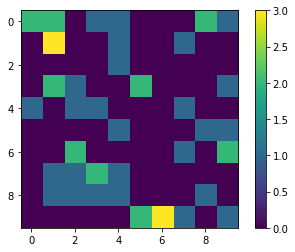

In [7]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar();

In [8]:
from mesa.datacollection import DataCollector

def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},  # `compute_gini` defined above
            agent_reporters={"Wealth": "wealth"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

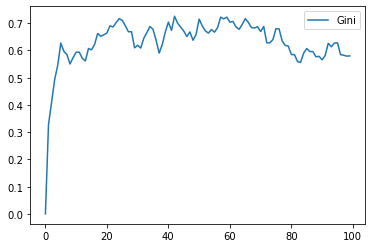

In [23]:
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()

gini = model.datacollector.get_model_vars_dataframe()
gini.plot();